In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import SymLogNorm
import h5py
from tqdm import tqdm

In [3]:
basePath = 'sims.TNG/TNG100-1/output'
fields = ['SubhaloMass','SubhaloSFRinRad']
snap = 99
subhalos = il.groupcat.loadSubhalos(basePath,snap,fields=fields)

In [27]:
halo_ID = 239993
tree = il.sublink.loadTree(basePath,snap,halo_ID)

In [25]:
print(len(tree['SnapNum'])) 

78371


In [28]:
tree['SubfindID']#.keys()

array([239993, 239262, 235073, ..., 240400, 240411, 239294], dtype=int32)

In [3]:
halo_ID = 239993
fields = ['Coordinates','Masses','ParticleIDs','GFM_StellarFormationTime']
stars  = il.snapshot.loadSubhalo(basePath,snap, halo_ID, 'stars', fields=fields)
# stars = il.snapshot.loadSubset(basePath,snap,'stars',fields=fields)

In [4]:
starsID = stars['ParticleIDs']
starsZ  = stars['GFM_StellarFormationTime']**-1 - 1
idx_remove   = np.where(starsZ < 0)
real_starsZ  = np.delete(starsZ,idx_remove)
real_starsId = np.delete(starsID,idx_remove)

In [5]:
redshifts = np.zeros(100)
numsnap = np.arange(0,99 + 1,1)
for i in range(len (numsnap)):
    header = il.groupcat.loadHeader(basePath, numsnap[i])
    redshifts[i] = header[ 'Redshift']
redshifts[-1] = 0

In [6]:
difference = real_starsZ[:,None] - redshifts
difference[difference < 0] = abs(difference.max()) + 1
starsSnap = np.argmin(difference, axis=1)
snap_to_look = np.unique(starsSnap)

In [7]:
def inverseMapPartIndicesToSubhaloIDs(indsType, SubhaloLenType, SnapOffsetsSubhalo, debug=False, flagFuzz=True):
    """ For a particle type ptName and snapshot indices for that type indsType, compute the
        subhalo ID to which each particle index belongs. 
        If flagFuzz is True (default), particles in FoF fuzz are marked as outside any subhalo,
        otherwise they are attributed to the closest (prior) subhalo.
    """
    gcLenType = SubhaloLenType[:,4]
    gcOffsetsType = SnapOffsetsSubhalo#[:-1]

    # val gives the indices of gcOffsetsType such that, if each indsType was inserted
    # into gcOffsetsType just -before- its index, the order of gcOffsetsType is unchanged
    # note 1: (gcOffsetsType-1) so that the case of the particle index equaling the
    # subhalo offset (i.e. first particle) works correctly
    # note 2: np.ss()-1 to shift to the previous subhalo, since we want to know the
    # subhalo offset index -after- which the particle should be inserted
    val = np.searchsorted( gcOffsetsType - 1, indsType ) - 1
    val = val.astype('int32')

    # search and flag all matches where the indices exceed the length of the
    # subhalo they have been assigned to, e.g. either in fof fuzz, in subhalos with
    # no particles of this type, or not in any subhalo at the end of the file
    if flagFuzz:
        gcOffsetsMax = gcOffsetsType + gcLenType - 1
        ww = np.where( indsType > gcOffsetsMax[val] )[0]

        if len(ww):
            val[ww] = -1

    if debug:
        # for all inds we identified in subhalos, verify parents directly
        for i in range(len(indsType)):
            if val[i] < 0:
                continue
            assert indsType[i] >= gcOffsetsType[val[i]]
            if flagFuzz:
                assert indsType[i] < gcOffsetsType[val[i]]+gcLenType[val[i]]
                assert gcLenType[val[i]] != 0

    return val

In [54]:
subhaloIDstars = np.zeros(len(real_starsId)) 
#np.loadtxt('SubhaloID_stars.txt').astype(int)
for i in tqdm(snap_to_look[31:], leave=True):
    all_starsID = il.snapshot.loadSubset(basePath,i,'stars',fields=['ParticleIDs'])

    stars_in = np.isin(all_starsID,real_starsId[starsSnap == i])
    indices  = np.arange(0,len(stars_in),1)
    stars_idx_snap = indices[stars_in] 

    ptType = 4 
    with h5py.File(il.groupcat.offsetPath(basePath,i),'r') as f:
        gcOffsetsType   = f['Subhalo/SnapByType'][:,ptType]

    gcLenType = il.groupcat.loadSubhalos(basePath, i, 'SubhaloLenType') 

    subhaloIDstars_snap = inverseMapPartIndicesToSubhaloIDs(stars_idx_snap,gcLenType,gcOffsetsType)

    subhaloIDstars[starsSnap == i] = subhaloIDstars_snap

    np.savetxt('SubhaloID_stars.txt', subhaloIDstars.astype(int))

    

  1%|▏         | 1/67 [02:11<2:24:53, 131.72s/it]

: 

: 

In [36]:
indices[stars_in] == indices[starsSnap == i]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 143951082 but corresponding boolean dimension is 321761

In [37]:
stars_in.shape

(143951082,)

In [30]:
a = np.isin(real_starsId[starsSnap == i],all_starsID)

array([ True,  True,  True, ...,  True,  True,  True])

In [34]:
starsSnap == i

array([False, False, False, ..., False, False, False])

In [11]:
snap_to_look[31:]

array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [12]:
all_starsID = il.snapshot.loadSubset(basePath,34,'stars',fields=['ParticleIDs'])


In [13]:
stars_in = np.isin(all_starsID,real_starsId)
indices  = np.arange(0,len(stars_in),1)
stars_idx_snap = indices[stars_in]

In [14]:
ptType = 4
with h5py.File(il.groupcat.offsetPath(basePath,34),'r') as f:
    gcOffsetsType   = f['Subhalo/SnapByType'][:,ptType]

In [15]:
gcLenType = il.groupcat.loadSubhalos(basePath, 34, 'SubhaloLenType') 

In [17]:
a = np.loadtxt('SubhaloID_stars.txt').astype(int)

a[np.isin(real_starsId,all_starsID)]

array([69290,     0, 69290, ...,    -1,    -1,    -1])

In [ ]:
'''
0-31 : loaded
31-
'''

In [ ]:
import matplotlib.colors as mcolors
def dominant_progenitor_histogram(X, Y, P, bins=100):
    """
    Compute the dominant progenitor for each bin in a 2D histogram based on coordinates X, Y and progenitors P.
    
    Parameters:
    - X, Y, P: arrays of shape N indicating the X and Y coordinates and progenitor IDs of the stars.
    - bins: number of bins or a sequence defining the bin edges
    
    Returns:
    - xedges, yedges: bin edges in the x and y directions
    - dominant_progenitor: 2D array indicating the dominant progenitor in each bin
    - cmap: colormap used for different progenitors
    """
    
    # Create a 2D histogram grid
    H, xedges, yedges = np.histogram2d(X, Y, bins=bins)
    
    # For each bin in the grid, determine the dominant progenitor
    dominant_progenitor = np.zeros(H.shape, dtype=int)
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            mask = (X >= xedges[i]) & (X < xedges[i+1]) & (Y >= yedges[j]) & (Y < yedges[j+1])
            unique, counts = np.unique(P[mask], return_counts=True)
            if len(unique) > 0:
                dominant_progenitor[i, j] = unique[np.argmax(counts)]

    # Define a colormap to color each progenitor differently
    colors = list(mcolors.TABLEAU_COLORS.values())
    cmap = mcolors.ListedColormap(colors[:len(np.unique(P))])
    
    return xedges, yedges, dominant_progenitor, cmap

In [ ]:
proj_1 = 0
proj_2 = 1
xedge,yedge,dominant,colmap = dominant_progenitor_histogram(stars['Coordinates'][:,proj_1],stars['Coordinates'][:,proj_2],subhaloIDstars)

def plot_dominant_progenitor(xedges, yedges, dominant_progenitor, cmap):
    """
    Plot the dominant progenitor for each bin in a 2D histogram.
    
    Parameters:
    - xedges, yedges: bin edges in the x and y directions
    - dominant_progenitor: 2D array indicating the dominant progenitor in each bin
    - cmap: colormap used for different progenitors
    """
    plt.figure(figsize=(10, 7))
    plt.pcolormesh(xedges, yedges, dominant_progenitor.T, cmap=cmap)
    plt.colorbar(ticks=np.arange(len(np.unique(dominant_progenitor))), label='Progenitor ID')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Dominant Progenitor in Each Bin')
    plt.show()

# Plotting using the function
plot_dominant_progenitor(xedge, yedge, dominant, colmap)

In [ ]:
proj_1 = 1
proj_2 = 2
xedge,yedge,dominant,colmap = dominant_progenitor_histogram(stars['Coordinates'][:,proj_1],stars['Coordinates'][:,proj_2],subhaloIDstars)

plot_dominant_progenitor(xedge, yedge, dominant, colmap)

In [42]:
snap0 = 99
snap1 = 90
i = 239993
tree = il.sublink.loadTree(basePath,snap0,i,fields=['SubfindID','SnapNum'],onlyMPB=True)

TreeIndex_at_snap1 = np.where(tree['SnapNum'] == snap1)
assert len(TreeIndex_at_snap1[0]) == 1

SubfindID_at_snap1 = tree['SubfindID'][TreeIndex_at_snap1]

particle_data = il.snapshot.loadSubhalo(basePath,snap1,SubfindID_at_snap1,'dm','Coordinates')

IndexError: index 1 is out of bounds for axis 0 with size 1

In [43]:
tree

{'count': 98,
 'SubfindID': array([239993, 239262, 235073, 235013, 232232, 231094, 229307, 228608,
        227401, 224702, 232166, 229192, 226434, 227345, 224483, 225395,
        220668, 218286, 216955, 213142, 211147, 204849, 201938, 198458,
        194187, 190626, 213781, 211211, 208536, 206265, 203693, 198948,
        192123, 186252, 182347, 175210, 169305, 163781, 157819, 148548,
        141313, 131755, 124423, 119265, 116328, 112065, 108487, 105070,
        102597,  95777,  92129,  88736,  86408,  82332,  77252,  75046,
         68602,  66428, 101492,  94410,  91875,  85553,  80403,  75271,
         79135,  74512,  69290,  62307,  65802,  57484,  52234,  47100,
         46375,  41528,  58035,  49854,  41672,  35210,  32468,  28454,
         22857,  19895,  22570,  19120,  18677,  14823,  13614,  18366,
         29562,  94476,  73318,  69678,  98829, 163494, 467009, 428336,
        190349, 415763], dtype=int32),
 'SnapNum': array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87,

In [37]:
fields = ['SubhaloID']

subhalos_before = il.groupcat.loadSubhalos(basePath,90)#,fields=fields)

In [39]:
subhalos_before['count']

4459038

In [19]:
def inverseMapPartIndicesToSubhaloIDs(sP, indsType, ptName, debug=False, flagFuzz=True, SubhaloLenType, SnapOffsetsSubhalo):
    """ For a particle type ptName and snapshot indices for that type indsType, compute the
        subhalo ID to which each particle index belongs. 
        If flagFuzz is True (default), particles in FoF fuzz are marked as outside any subhalo,
        otherwise they are attributed to the closest (prior) subhalo.
    """
    gcLenType = SubhaloLenType[:,sP.ptNum(ptName)]
    gcOffsetsType = SnapOffsetsSubhalo[:,sP.ptNum(ptName)][:-1]

    # val gives the indices of gcOffsetsType such that, if each indsType was inserted
    # into gcOffsetsType just -before- its index, the order of gcOffsetsType is unchanged
    # note 1: (gcOffsetsType-1) so that the case of the particle index equaling the
    # subhalo offset (i.e. first particle) works correctly
    # note 2: np.ss()-1 to shift to the previous subhalo, since we want to know the
    # subhalo offset index -after- which the particle should be inserted
    val = np.searchsorted( gcOffsetsType - 1, indsType ) - 1
    val = val.astype('int32')

    # search and flag all matches where the indices exceed the length of the
    # subhalo they have been assigned to, e.g. either in fof fuzz, in subhalos with
    # no particles of this type, or not in any subhalo at the end of the file
    if flagFuzz:
        gcOffsetsMax = gcOffsetsType + gcLenType - 1
        ww = np.where( indsType > gcOffsetsMax[val] )[0]

        if len(ww):
            val[ww] = -1

    if debug:
        # for all inds we identified in subhalos, verify parents directly
        for i in range(len(indsType)):
            if val[i] < 0:
                continue
            assert indsType[i] >= gcOffsetsType[val[i]]
            if flagFuzz:
                assert indsType[i] < gcOffsetsType[val[i]]+gcLenType[val[i]]
                assert gcLenType[val[i]] != 0

    return val

SyntaxError: non-default argument follows default argument (3111884120.py, line 1)

In [11]:
np.floor(z)

array([3., 4., 3., ..., 3., 4., 3.], dtype=float32)

In [4]:
tracers.keys()

dict_keys(['count'])

In [5]:
tracers['count']

0

In [19]:
fields = ['Coordinates', 'Masses','ParticleIDs']
halo_ID = 239993
tree = il.sublink.loadTree(basePath,snap,halo_ID,onlyMPB=True)
subfind = tree['SubfindID']
idx_1 = 0
idx_2 = 15
idx_3 = 20
stars   = il.snapshot.loadSubhalo(basePath,int(99-idx_1), subfind[idx_1], 'stars', fields=fields)
stars_2 = il.snapshot.loadSubhalo(basePath,int(99-idx_2), subfind[idx_2], 'stars', fields=fields)
stars_3 = il.snapshot.loadSubhalo(basePath,int(99-idx_3), subfind[idx_3], 'stars', fields=fields)

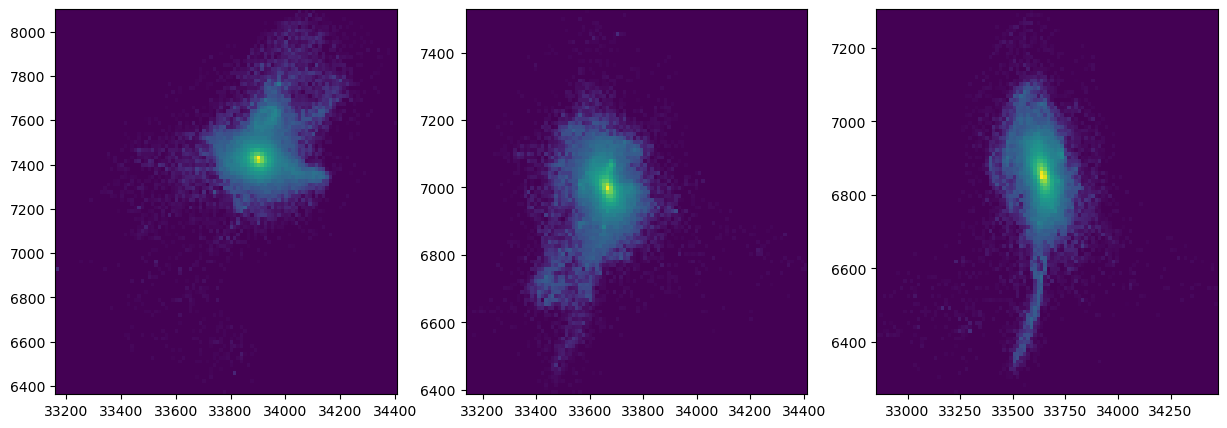

In [21]:
proj_1 = 1
proj_2 = 0
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist2d(stars['Coordinates'][:,proj_1],stars['Coordinates'][:,proj_2],weights=stars['Masses'],bins=100,norm=SymLogNorm(0.001));
plt.subplot(1,3,2)
plt.hist2d(stars_2['Coordinates'][:,proj_1],stars_2['Coordinates'][:,proj_2],weights=stars_2['Masses'],bins=100,norm=SymLogNorm(0.001));
plt.subplot(1,3,3)
plt.hist2d(stars_3['Coordinates'][:,proj_1],stars_3['Coordinates'][:,proj_2],weights=stars_3['Masses'],bins=100,norm=SymLogNorm(0.001));


In [24]:
stars_id_99 = stars['ParticleIDs']
stars_id_98 = stars_2['ParticleIDs']
stars_id_84 = stars_3['ParticleIDs']

idx_not_both = np.isin(stars_id_99,stars_id_98, invert=True)
idx_not_both.sum()

12823

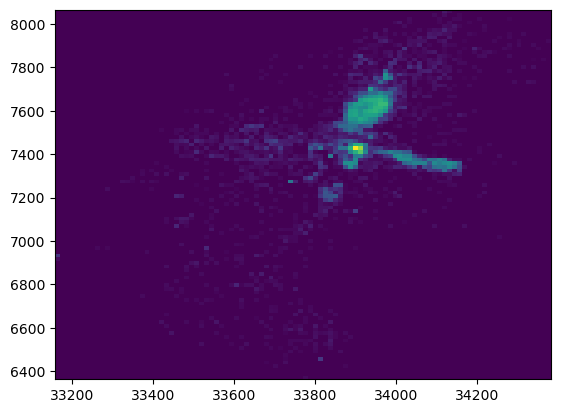

In [35]:
plt.hist2d(stars['Coordinates'][idx_not_both,proj_1],stars['Coordinates'][idx_not_both,proj_2],weights=stars['Masses'][idx_not_both],bins=100,norm=SymLogNorm(0.001));

In [18]:
plot_stars = stars_3
stars_mass = plot_stars['Masses']
stars_mass_keep = plot_stars['Masses'][idx_not_both]
stars_y = plot_stars['Coordinates'][:,1]
stars_z = plot_stars['Coordinates'][:,2]
stars_y_keep = plot_stars['Coordinates'][idx_not_both,1]
stars_z_keep = plot_stars['Coordinates'][idx_not_both,2]
plt.subplot(1,2,1)
plt.hist2d(stars_y,stars_z,weights=stars_mass,bins=100,norm='log');
plt.subplot(1,2,2)
plt.hist2d(stars_y_keep,stars_z_keep,bins=10);

IndexError: boolean index did not match indexed array along dimension 0; dimension is 301165 but corresponding boolean dimension is 321798

In [80]:
center_x = np.mean(stars['Coordinates'][:,0])
center_y = np.mean(stars['Coordinates'][:,1])
center_z = np.mean(stars['Coordinates'][:,2])

stars_x = stars['Coordinates'][:,0] #- center_x
stars_y = stars['Coordinates'][:,1] #- center_y
stars_z = stars['Coordinates'][:,2] #- center_z

# birth_x = stars['BirthPos'][:,0] #- center_x
# birth_y = stars['BirthPos'][:,1] #- center_y
# birth_z = stars['BirthPos'][:,2] #- center_z

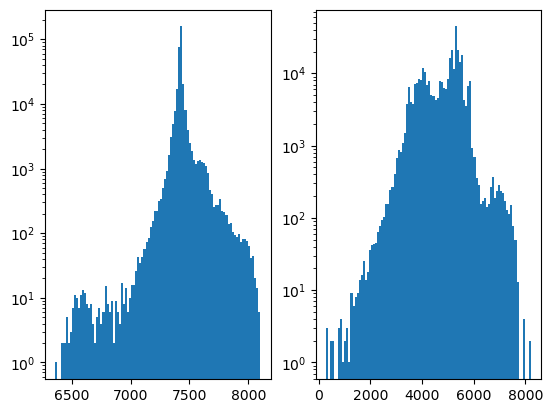

In [ ]:
plt.subplot(1,2,1)
plt.hist(stars_x,bins=100);
plt.yscale('log')
plt.subplot(1,2,2)
plt.yscale('log')
plt.hist(birth_x,bins=100);

In [78]:
r = np.sqrt(stars_x**2+stars_y**2+stars_z**2)
r_birth = np.sqrt(birth_x**2+birth_y**2+birth_z**2)

NameError: name 'birth_x' is not defined

NameError: name 'r_birth' is not defined

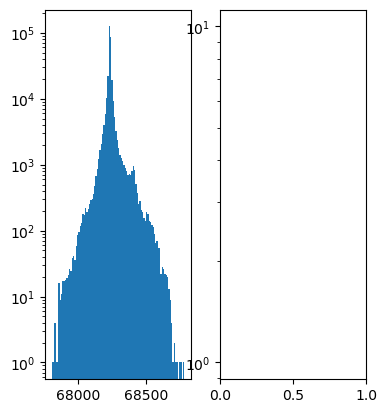

In [79]:
plt.subplot(1,3,1)
plt.hist(r,bins=100);
plt.yscale('log')
plt.subplot(1,3,2)
plt.yscale('log')
plt.hist(r_birth,bins=100);
plt.subplot(1,3,3)
plt.yscale('log')
plt.hist(abs(r-r_birth),bins=100);

In [172]:
idx_small = abs(r-r_birth) < 4000
idx_big   = 3000 < abs(r-r_birth)
idx_exsitu = idx_small*idx_big

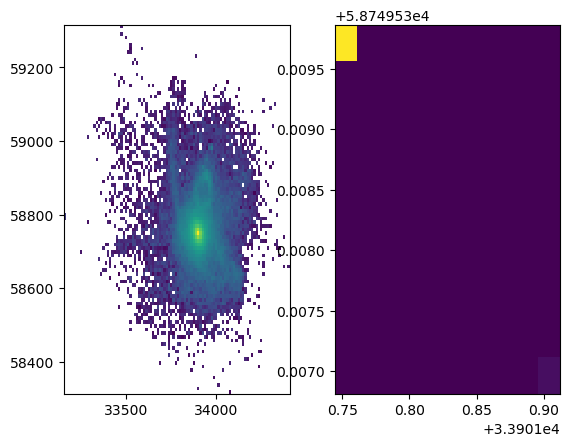

In [92]:
stars_mass = stars['Masses']
plt.subplot(1,2,1)
plt.hist2d(stars_y,stars_z,weights=stars_mass,bins=100,norm='log');
plt.subplot(1,2,2)
plt.hist2d(stars_y[idx_not_both],stars_z[idx_not_both],weights=stars_mass[idx_not_both],bins=100);

In [44]:
tree = il.sublink.loadTree(basePath,snap_1,haloID,onlyMPB=True)#,fields='all',onlyMPB=True)

In [45]:
tree.keys()

dict_keys(['count', 'DescendantID', 'FirstProgenitorID', 'FirstSubhaloInFOFGroupID', 'GroupBHMass', 'GroupBHMdot', 'GroupCM', 'GroupFirstSub', 'GroupGasMetalFractions', 'GroupGasMetallicity', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupPos', 'GroupSFR', 'GroupStarMetalFractions', 'GroupStarMetallicity', 'GroupVel', 'GroupWindMass', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200', 'LastProgenitorID', 'MainLeafProgenitorID', 'Mass', 'MassHistory', 'NextProgenitorID', 'NextSubhaloInFOFGroupID', 'NumParticles', 'RootDescendantID', 'SnapNum', 'SubfindID', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHal

In [57]:
tree['SubfindID']

array([239993, 239262, 235073, 235013, 232232, 231094, 229307, 228608,
       227401, 224702, 232166, 229192, 226434, 227345, 224483, 225395,
       220668, 218286, 216955, 213142, 211147, 204849, 201938, 198458,
       194187, 190626, 213781, 211211, 208536, 206265, 203693, 198948,
       192123, 186252, 182347, 175210, 169305, 163781, 157819, 148548,
       141313, 131755, 124423, 119265, 116328, 112065, 108487, 105070,
       102597,  95777,  92129,  88736,  86408,  82332,  77252,  75046,
        68602,  66428, 101492,  94410,  91875,  85553,  80403,  75271,
        79135,  74512,  69290,  62307,  65802,  57484,  52234,  47100,
        46375,  41528,  58035,  49854,  41672,  35210,  32468,  28454,
        22857,  19895,  22570,  19120,  18677,  14823,  13614,  18366,
        29562,  94476,  73318,  69678,  98829, 163494, 467009, 428336,
       190349, 415763], dtype=int32)

In [46]:
tree['SnapNum']

array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83,
       82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66,
       65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49,
       48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32,
       31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2], dtype=int16)

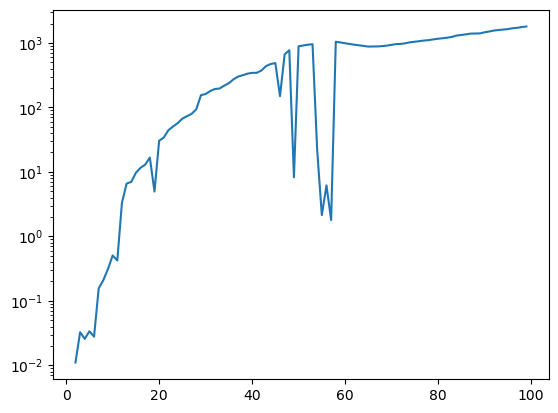

In [47]:
plt.plot(tree['SnapNum'],tree['SubhaloMass'])
plt.yscale('log')

In [51]:
tree['GroupPos'].shape

(78371, 3)

In [52]:
group_mass = tree['GroupMass']
group_x = tree['GroupPos'][:,0]
group_y = tree['GroupPos'][:,1]
group_z = tree['GroupPos'][:,2]

([], [])

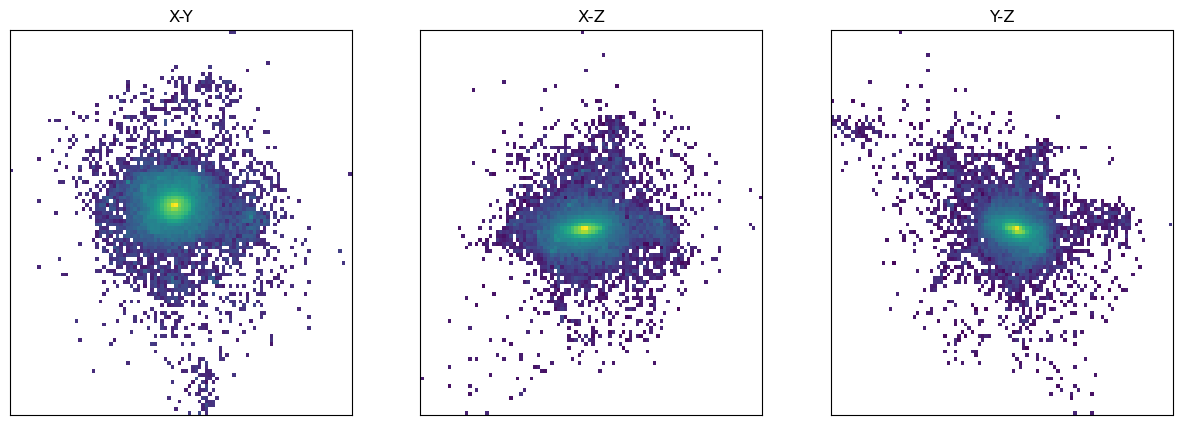

In [18]:
stars_x = stars_99['Coordinates'][:,0]
stars_y = stars_99['Coordinates'][:,1]
stars_z = stars_99['Coordinates'][:,2]
stars_mass = stars_99['Masses']
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('X-Y')
plt.hist2d(stars_x,stars_y,weights=stars_mass,bins=100,norm='log');
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
plt.title('X-Z')
plt.hist2d(stars_x,stars_z,weights=stars_mass,bins=100,norm='log');
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
plt.title('Y-Z')
plt.hist2d(stars_y,stars_z,weights=stars_mass,bins=100,norm='log');
plt.xticks([])
plt.yticks([])